# Marsh grass herbivory

This notebook demonstrates coupling of an ABM implemented in Mesa and a grid-based numerical model written in Landlab. The example is adpated from the canonical "wolf-sheep-grass" example of an agent-based model. Here we remove the wolves, convert the sheep to a general herbivore, and add in salt marsh ecogeomorphic evolution: when herbivore eats the marsh grass, the sediments becomes more erodible, and the roughness is reduced. 

The rules in this example are deliberately simple. The main goal of this tutorial is to illustrate the mechanics of building an integrated model that combines agent-based elements (via Mesa) with continuum-based elements (via Landlab) on a shared grid.

*(Greg Tucker, June 2020; most recent update November 2021)*

## Running the Mesa Herbivore-Grass model by itself

To start, here's an example of how to run a Mesa model in a notebook. First, we'll run a check to make sure Mesa is installed and available; if it is not, follow the instructions in the message to install it, then re-start the kernel (Kernel => Restart) and continue.

In [1]:
try:
    from mesa import Model
except ModuleNotFoundError:
    print(
        """
Mesa needs to be installed in order to run this notebook.

Normally Mesa should be pre-installed alongside the Landlab notebook collection.
But it appears that Mesa is not already installed on the system on which you are
running this notebook. You can install Mesa from a command prompt using either:

`conda install -c conda-forge mesa`

or

`pip install mesa`
"""
    )
    raise

Next, we'll define a Mesa model object, representing the herbivore-marsh grass model. Note that this Mesa code in the cell below, which implements the herbivore-grass example, was adapted from the wolf-sheep-grass model from the Mesa development team; the original can be found [here](https://github.com/projectmesa/mesa/tree/main/examples/wolf_sheep).

In [2]:
from collections import defaultdict

from mesa import Agent
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid
from mesa.time import RandomActivationByType
from typing import Callable, Optional, Type


class RandomActivationByTypeFiltered(RandomActivationByType):
    """
    A scheduler that overrides the get_type_count method to allow for filtering
    of agents by a function before counting.

    Example:
    >>> scheduler = RandomActivationByTypeFiltered(model)
    >>> scheduler.get_type_count(AgentA, lambda agent: agent.some_attribute > 10)
    """

    def get_type_count(
        self,
        type_class: Type[Agent],
        filter_func: Optional[Callable[[Agent], bool]] = None,
    ) -> int:
        """
        Returns the current number of agents of certain type in the queue
        that satisfy the filter function.
        """
        if type_class not in self.agents_by_type:
            return 0
        count = 0
        for agent in self.agents_by_type[type_class].values():
            if filter_func is None or filter_func(agent):
                count += 1
        return count

class RandomWalker(Agent):
    """
    Class implementing random walker methods in a generalized manner.

    Not indended to be used on its own, but to inherit its methods to multiple
    other agents.

    """

    grid = None
    x = None
    y = None
    moore = True

    def __init__(self, unique_id, pos, model, moore=True):
        """
        grid: The MultiGrid object in which the agent lives.
        x: The agent's current x coordinate
        y: The agent's current y coordinate
        moore: If True, may move in all 8 directions.
                Otherwise, only up, down, left, right.
        """
        super().__init__(unique_id, model)
        self.pos = pos
        self.moore = moore

    def random_move(self):
        """
        Step one cell in any allowable direction.
        """
        # Pick the next cell from the adjacent cells.
        next_moves = self.model.grid.get_neighborhood(self.pos, self.moore, True)
        next_move = self.random.choice(next_moves)
        # Now move:
        self.model.grid.move_agent(self, next_move)


class Herbivore(RandomWalker):
    """
    A herbivore that walks around, reproduces (asexually) and eats grass.

    The init is the same as the RandomWalker.
    """

    energy = None

    def __init__(self, unique_id, pos, model, moore, energy=None, food_preference=400):
        #Herbivore(self.next_id(), (x, y), self, True, energy)
        super().__init__(unique_id, pos, model, moore=moore)
        self.energy = energy
        self.food_preference = food_preference

    def step(self):
        """
        A model step. Move, then eat grass and reproduce.
        """
        self.random_move()
        living = True

        if self.model.grass:
            # Reduce energy
            self.energy -= 15

            # If there is grass available, eat it
            this_cell = self.model.grid.get_cell_list_contents([self.pos])
            grass_patch = [obj for obj in this_cell if isinstance(obj, GrassPatch)][0]
            if grass_patch.biomass > self.food_preference:
                self.energy += self.model.herbivore_gain_from_food
                grass_patch.fully_grown = False
                grass_patch.biomass -= self.model.grass_loss_from_grazing

            # Death
            if self.energy < 0:
                # self.model.grid._remove_agent(self.pos, self)
                self.model.grid.remove_agent(self)
                self.model.schedule.remove(self)
                living = False

        if living and self.random.random() < self.model.herbivore_reproduce:
            # Create a new sheep:
            if self.model.grass:
                self.energy /= 2
            juvenile = Herbivore(
                self.model.next_id(), self.pos, self.model, self.moore, self.energy
            )
            self.model.grid.place_agent(juvenile, self.pos)
            self.model.schedule.add(juvenile)


class GrassPatch(Agent):
    """
    A patch of grass that grows at a fixed rate and it is eaten by an herbivore
    """

    def __init__(self, unique_id, pos, model, fully_grown, countdown, max_biomass):
        """
        Creates a new patch of grass

        Args:
            grown: (boolean) Whether the patch of grass is fully grown or not
            countdown: Time for the patch of grass to be fully grown again
        """
        super().__init__(unique_id, model)
        self.countdown = countdown
        self.fully_grown = fully_grown
        self.max_biomass = max_biomass
        if self.fully_grown:
            self.percent_of_max = 1.0
            self.biomass = max_biomass
        else:
            self.percent_of_max =  (self.model.grass_regrowth_time - self.countdown) / self.model.grass_regrowth_time
            self.biomass = self.percent_of_max * self.max_biomass     
        
        self.pos = pos

    def step(self):
        if not self.fully_grown:
            if self.countdown <= 0:
                self.fully_grown = True
                self.countdown = self.model.grass_regrowth_time
                self.percent_of_max = 1
                self.biomass = self.max_biomass
            else:
                self.percent_of_max = (self.model.grass_regrowth_time - self.countdown) / self.model.grass_regrowth_time
                self.biomass = self.percent_of_max * self.max_biomass
                self.countdown -= 1



"""
Wolf-Sheep Predation Model
================================

Replication of the model found in NetLogo:
    Wilensky, U. (1997). NetLogo Wolf Sheep Predation model.
    http://ccl.northwestern.edu/netlogo/models/WolfSheepPredation.
    Center for Connected Learning and Computer-Based Modeling,
    Northwestern University, Evanston, IL.
"""


class HerbivoreGrass(Model):
    """
    Herbivore Grass Model
    """

    height = 20
    width = 20

    initial_herbivores = 100

    herbivore_reproduce = 0.04

    grass = False
    grass_regrowth_time = 30
    herbivore_gain_from_food = 4

    verbose = False  # Print-monitoring

    description = (
        "A model for simulating wolf and sheep (predator-prey) ecosystem modelling."
    )

    def __init__(
        self,
        height=20,
        width=20,
        initial_herbivores=100,
        herbivore_reproduce=0.02,
        grass=False,
        grass_regrowth_time=12,
        grass_loss_from_grazing=100,
        grass_max_biomass=700,
        herbivore_gain_from_food=50,
        verbose=False
    ):
        """
        Create a new Wolf-Sheep model with the given parameters.

        Args:
            initial_sheep: Number of sheep to start with
            initial_wolves: Number of wolves to start with
            sheep_reproduce: Probability of each sheep reproducing each step
            wolf_reproduce: Probability of each wolf reproducing each step
            wolf_gain_from_food: Energy a wolf gains from eating a sheep
            grass: Whether to have the sheep eat grass for energy
            grass_regrowth_time: How long it takes for a grass patch to regrow
                                 once it is eaten
            herbivore_gain_from_food: Energy herbivore gain from grass, if enabled.
        """
        super().__init__(verbose=verbose)
        # Set parameters
        self.height = height
        self.width = width
        self.initial_herbivores = initial_herbivores
        self.herbivore_reproduce = herbivore_reproduce
        self.grass = grass
        self.grass_regrowth_time = grass_regrowth_time
        self.grass_loss_from_grazing = grass_loss_from_grazing
        self.herbivore_gain_from_food = herbivore_gain_from_food
        self.verbose = verbose

        self.schedule = RandomActivationByTypeFiltered(self)
        self.grid = MultiGrid(self.height, self.width, torus=True)
        self.datacollector = DataCollector(
            {
                "Herbivores": lambda m: m.schedule.get_type_count(Herbivore),
                "Grass": lambda m: m.schedule.get_type_count(
                    GrassPatch, lambda x: x.fully_grown
                ),
            }
        )

        # Create herbivores:
        for i in range(self.initial_herbivores):
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            energy = self.random.randrange(2 * self.herbivore_gain_from_food)
            herbivore = Herbivore(
                self.next_id(), 
                (x, y), 
                self, 
                True, 
                energy,
                food_preference=350
                )
            self.grid.place_agent(herbivore, (x, y))
            self.schedule.add(herbivore)

        # Create grass patches
        if self.grass:
            for agent, (x, y) in self.grid.coord_iter():
                fully_grown = self.random.choice([True, False])

                if fully_grown:
                    countdown = self.grass_regrowth_time
                else:
                    countdown = self.random.randrange(self.grass_regrowth_time)

                patch = GrassPatch(self.next_id(), (x, y), self, fully_grown, countdown, grass_max_biomass)
                self.grid.place_agent(patch, (x, y))
                self.schedule.add(patch)

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)
        if self.verbose:
            print(
                [
                    self.schedule.time,
                    self.schedule.get_type_count(Herbivore),
                ]
            )

    def run_model(self, step_count=200):
        if self.verbose:
            print("Initial number herbivores: ", self.schedule.get_type_count(Herbivore))

        for i in range(step_count):
            self.step()

        if self.verbose:
            print("")
            print("Final number herbivores: ", self.schedule.get_type_count(Herbivore))

Create an instance of the WolfSheep model, with the `grass` option set to `True`:

In [3]:
hs = HerbivoreGrass(grass=True, verbose=True)

/tmp/ipykernel_10853/4289568898.py:263: UserWarning: Agent 1 is being placed with
place_agent() despite already having the position (9, 15). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(herbivore, (x, y))
/tmp/ipykernel_10853/4289568898.py:263: UserWarning: Agent 2 is being placed with
place_agent() despite already having the position (8, 14). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(herbivore, (x, y))
/tmp/ipykernel_10853/4289568898.py:263: UserWarning: Agent 3 is being placed with
place_agent() despite already having the position (1, 2). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(herbivore, (x, y))
/tmp/ipykernel_10853/4289568898.py:263: UserWarning: Agent 4 is being placed with
place_agent() despite already having the po

Define a function to set up an array representing the growth status of grass on the model grid (in other words, extract the information from the model's GrassPatch agents), as well as a function to plot the current grass status. This is really a translation of data structures: the Mesa model stores data inside agents, which themselves reside at particular grid cells. Here we want to extract the information pertaining to the status of each cell's GrassPatch---is it fully grown or "damaged"---and store that information in a simple 2D numpy array.

In [4]:
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

ground_cover_cmap = copy.copy(mpl.colormaps["YlGn"])


def generate_grass_map(model):
    grass_map = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, (x, y) = cell
        for agent in cell_content:
            if type(agent) is GrassPatch:
                grass_map[x][y] = agent.biomass

    return grass_map

def plot_grass_map(grass_map):
    plt.imshow(grass_map, interpolation="nearest", cmap=ground_cover_cmap)
    plt.colorbar()

Run the model and display the results:

/tmp/ipykernel_10853/4289568898.py:29: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  if type_class not in self.agents_by_type:
/tmp/ipykernel_10853/4289568898.py:32: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.agents_by_type[type_class].values():
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 501 is being placed with
place_agent() despite already having the position (6, 16). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 502 is being placed with


Initial number herbivores:  100
[1, 99]
[2, 97]
[3, 100]
[4, 103]
[5, 105]
[6, 106]
[7, 104]
[8, 105]
[9, 105]
[10, 108]
[11, 110]
[12, 116]
[13, 117]
[14, 120]
[15, 122]
[16, 127]
[17, 131]
[18, 134]
[19, 137]
[20, 139]
[21, 140]
[22, 142]
[23, 145]
[24, 147]
[25, 151]

Final number herbivores:  151


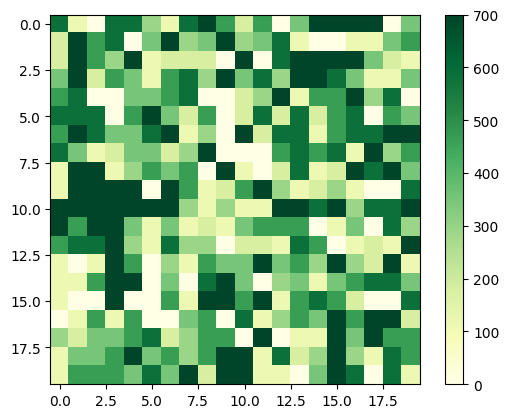

In [5]:
hs.run_model(step_count=25)
gm = generate_grass_map(hs)
plot_grass_map(gm)

## One-way coupling: using the grass cover in the marsh model

Here we initialize and run the herbivore-grass model for a short duration. We then extract its map of grass as a percent of the max biomass, and use that to modify the roughness in a tidal flow circulation model.

Initial number herbivores:  100
[1, 99]
[2, 99]
[3, 99]

Final number herbivores:  99


/tmp/ipykernel_10853/4289568898.py:263: UserWarning: Agent 1 is being placed with
place_agent() despite already having the position (16, 3). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(herbivore, (x, y))
/tmp/ipykernel_10853/4289568898.py:263: UserWarning: Agent 2 is being placed with
place_agent() despite already having the position (18, 1). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(herbivore, (x, y))
/tmp/ipykernel_10853/4289568898.py:263: UserWarning: Agent 3 is being placed with
place_agent() despite already having the position (18, 18). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(herbivore, (x, y))
/tmp/ipykernel_10853/4289568898.py:263: UserWarning: Agent 4 is being placed with
place_agent() despite already having the 

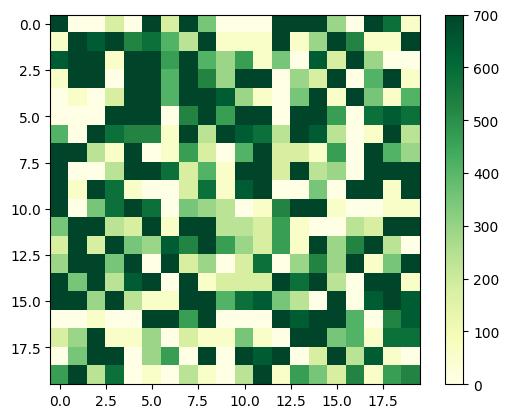

In [6]:
hs = HerbivoreGrass(grass=True, verbose=True)
hs.run_model(step_count=3)
gm = generate_grass_map(hs)
plot_grass_map(gm)

Import from Landlab a `RasterModelGrid` (which will be Landlab's version of the model grid), the `imshow_grid` function (for plotting Landlab grid fields), and the `TidalFlowCalculator` component (which update tidal current patterns based on plant cover).

In [7]:
import copy

import matplotlib as mpl

from landlab import RasterModelGrid, imshow_grid
from landlab.components import TidalFlowCalculator
from landlab.grid.mappers import map_max_of_link_nodes_to_link

We set up our plotting methods here to view `TidalFlowCalculator` output.

In [8]:
from landlab.grid.mappers import map_link_vector_components_to_node, map_max_of_node_links_to_node


def map_velocity_components_to_nodes(grid):
    """Map the velocity components from the links to the nodes, and return the node arrays."""
    ebb_vel_x, ebb_vel_y = map_link_vector_components_to_node(
        grid, grid.at_link["ebb_tide_flow__velocity"]
    )
    flood_vel_x = -ebb_vel_x
    flood_vel_y = -ebb_vel_y
    return (ebb_vel_x, ebb_vel_y, flood_vel_x, flood_vel_y)


def plot_tidal_flow(grid, resample=1):
    (ebb_x, ebb_y, flood_x, flood_y) = map_velocity_components_to_nodes(grid)

    # depth
    plt.figure()
    imshow_grid(
        grid, grid.at_node["mean_water__depth"], cmap="YlGnBu", color_for_closed="g"
    )
    plt.title("Water depth (m)")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

    # down-sample for legible quiver plots if needed
    if resample != 1:
        xr = grid.x_of_node.reshape(
            (grid.number_of_node_rows, grid.number_of_node_columns)
        )[::resample, ::resample]
        yr = grid.y_of_node.reshape(
            (grid.number_of_node_rows, grid.number_of_node_columns)
        )[::resample, ::resample]
        ebb_xr = ebb_x.reshape((grid.number_of_node_rows, grid.number_of_node_columns))[
            ::resample, ::resample
        ]
        ebb_yr = ebb_y.reshape((grid.number_of_node_rows, grid.number_of_node_columns))[
            ::resample, ::resample
        ]
        fld_xr = flood_x.reshape(
            (grid.number_of_node_rows, grid.number_of_node_columns)
        )[::resample, ::resample]
        fld_yr = flood_y.reshape(
            (grid.number_of_node_rows, grid.number_of_node_columns)
        )[::resample, ::resample]
    else:
        xr = grid.x_of_node
        yr = grid.y_of_node
        ebb_xr = ebb_x
        ebb_yr = ebb_y
        fld_xr = flood_x
        fld_yr = flood_y

    # ebb tide
    plt.figure()
    imshow_grid(grid, grid.at_node["topographic__elevation"])
    plt.quiver(xr, yr, ebb_xr, ebb_yr)
    plt.title("Ebb Tide")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

    ebb_vel_magnitude = np.sqrt(ebb_x * ebb_x + ebb_y * ebb_y)
    plt.figure()
    imshow_grid(grid, ebb_vel_magnitude, cmap="magma", color_for_closed="g")
    plt.title("Ebb Tide Velocity Magnitude (m/s)")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

    # flood tide
    plt.figure()
    imshow_grid(grid, grid.at_node["topographic__elevation"])
    plt.quiver(xr, yr, fld_xr, fld_yr)
    plt.title("Flood Tide")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

    plt.figure()
    flood_vel_magnitude = np.sqrt(flood_x * flood_x + flood_y * flood_y)
    imshow_grid(grid, flood_vel_magnitude, cmap="magma", color_for_closed="g")
    plt.title("Flood Tide Velocity Magnitude (m/s)")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

In [9]:
# Function to calculate inundation time
def floodTimeTrig(z, tidal_parameters):
  datum_high=(
      (tidal_parameters["tidal_range"]/2 
       + tidal_parameters["mean_sea_level"]) 
       * np.ones(z.size)
  )
  datum_low=(
    (-tidal_parameters["tidal_range"]/2 
     + tidal_parameters["mean_sea_level"])
     *np.ones(z.size)
  )
  tidal_period=tidal_parameters["tidal_period"]
  # If elevation is above the tidal range indation time is 0
  datum_high[z>=datum_high] = z[z>=datum_high]
  
  # If elevation is below inundation time is a full tidal cycle
  datum_low[z<=datum_low] = z[z<=datum_low]
  
  # Rising time over cell = 6.21 (A/pi - 1)	
  # where A = 2* pi - cos-1 [2 (height of cell – meanLowWater) / (meanHighWater – meanLowWater) - 1] radians
  A1 = 2 * np.pi - np.arccos(2 * (z - datum_low) / (datum_high - datum_low) - 1)
  rising_time = tidal_period / 2 * (A1 / np.pi - 1)
  
  # Falling time over cell = 6.21 (A/pi - 1) where
  # A = 2* - cos-1 [2 (height of cell – meanHighWater) / (meanLowWater – meanHighWater) - 1] radians
  A2 = 2 * np.pi - np.arccos(2 * (z - datum_high) / (datum_low - datum_high) - 1)
  falling_time = tidal_period / 2 * (A2 / np.pi - 1)
  
  # If between inundation time = abs (time rising - 6.21) + time falling
  inundation_time = np.abs(rising_time - tidal_period/2) + falling_time
  
  return inundation_time

# Function to calculate biomass as a function of inundation time

def solve_biomass_inundation_curve(
        inundation, 
        biomass_parameters,
        ):
    biomass_max = biomass_parameters["biomass_max"]
    inun_veg_max = biomass_parameters["max_inundation"]
    inun_veg_min = biomass_parameters["min_inundation"]
    inun_veg_peak = biomass_parameters["inundation_at_peak_biomass"]
  # Stop the function if there are invalid parameters
    if (
        (np.any(biomass_max < 0)) 
        | (np.any(inun_veg_max <= np.fmax(inun_veg_min, inun_veg_peak))) 
        | (np.any(inun_veg_min >= np.fmax(inun_veg_max, inun_veg_peak)))
        ):
       return ("Invalid parameters were defined.")
    else:
        conditions = [
          np.isnan(inun_veg_peak),
          (inundation <= inun_veg_peak),
          (inundation > inun_veg_peak)
        ]
       # If there is no peak elevation for vegetation parabola is symmetric.
        midpoint = (inun_veg_max - inun_veg_min) / 2
        upper_z_veg_min = inun_veg_peak-((inun_veg_max-inun_veg_peak)) 
        lower_z_veg_max = inun_veg_peak+((inun_veg_peak-inun_veg_min))
      
        # From bmax, min, and max elevation limits, solve for parameters of a parabola.
        a_choices  = [
          (-inun_veg_min * biomass_max - inun_veg_max * biomass_max) / ((inun_veg_min - midpoint) * (-inun_veg_max + midpoint)),
          -((-inun_veg_min * biomass_max - lower_z_veg_max * biomass_max) / ((inun_veg_min - inun_veg_peak) * (-lower_z_veg_max + inun_veg_peak))),
          -((-upper_z_veg_min * biomass_max - inun_veg_max * biomass_max) / ((upper_z_veg_min - inun_veg_peak) * (-inun_veg_max + inun_veg_peak)))
        ]

        b_choices = [
          -(biomass_max / ((inun_veg_min - inun_veg_peak) * (-inun_veg_max + inun_veg_peak))),
          -(biomass_max / ((inun_veg_min - inun_veg_peak) * (-lower_z_veg_max + inun_veg_peak))),
          -(biomass_max / ((upper_z_veg_min - inun_veg_peak) * (-inun_veg_max + inun_veg_peak)))
        ]

        c_choices = [
          (inun_veg_min * inun_veg_max * biomass_max) / ((inun_veg_min - inun_veg_peak) * (inun_veg_max - inun_veg_peak)),
          (inun_veg_min * lower_z_veg_max * biomass_max) / ((inun_veg_min - inun_veg_peak) * (lower_z_veg_max - inun_veg_peak)),
          (upper_z_veg_min * inun_veg_max * biomass_max) / ((upper_z_veg_min - inun_veg_peak) * (inun_veg_max - inun_veg_peak))
        ]
        
        a = np.select(conditions, a_choices)
        b = np.select(conditions, b_choices)
        c = np.select(conditions, c_choices)
        # Apply parabolic function to elevation to calulate above ground biomass.
        abg = a * inundation + b * inundation**2 + c
        abg[abg < 0] = 0.0
    return abg

# Function to calculate roughness as a function of biomass

def calculate_variable_roughness(
        grid, 
        depth_variable = True,
        stem_diameter=0.006, 
        stem_height=0.7,
        drag_coefficient=1.2,
        stem_density_range = np.array([0, 500, 2250]),
        biomass_range = np.array([0, 50, 700])
    ):
    grid_stem_density = np.interp(grid.at_node["biomass"], biomass_range, stem_density_range)
    grid_a = stem_diameter * grid_stem_density
    # If we use the mean depth, we calculate much smaller Manning's coefficient values due to the dependence on depth 
    if depth_variable:
        variable_mannings = (
            1 * (drag_coefficient * grid_a
            * grid.at_node["mean_water__depth"] 
            / (2 * 9.81) * grid.at_node["mean_water__depth"]**(1/6))
        )
    else: 
        # If we assume Manning's coefficient is constant for all emergent depths, we can use the vegetation height in place of the depth
        variable_mannings = (
            1 * (drag_coefficient * grid_a
            * stem_height / (2 * 9.81) * stem_diameter**(1/6))
        )
    variable_mannings[variable_mannings < 0.01] = 0.01
    return variable_mannings

# Simple sediment deposition function (no hydraulics)

def estimate_allochtonous_deposition_per_tide(grid, peak_biomass=700, suspended_sediment=30, density_sediment=2650*(1-0.7)):
    suspended_sediment_kg_m3 = suspended_sediment / 1000
    depth = grid.at_node["mean_water__depth"]
    capture_efficiency = grid.at_node["biomass"] / peak_biomass
    capture_efficiency[capture_efficiency<=0] = 0.15
    sed_deposition = suspended_sediment_kg_m3 * depth * capture_efficiency / density_sediment
    return sed_deposition
  

Create a larger Mesa grid that we will share with Landlab to produce a simple marsh flow model.

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Initial number herbivores:  100
[1, 98]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40101 is being placed with
place_agent() despite already having the position (88, 141). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40102 is being placed with
place_agent() despite already having the position (31, 65). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40103 is being placed with
place_agent() despite already having the position (176, 198). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40104 is being placed with

[2, 100]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40106 is being placed with
place_agent() despite already having the position (59, 153). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40107 is being placed with
place_agent() despite already having the position (69, 109). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)


[3, 101]
[4, 101]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40108 is being placed with
place_agent() despite already having the position (91, 9). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40109 is being placed with
place_agent() despite already having the position (27, 8). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)


[5, 103]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40110 is being placed with
place_agent() despite already having the position (131, 107). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40111 is being placed with
place_agent() despite already having the position (105, 128). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)


[6, 105]
[7, 105]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40112 is being placed with
place_agent() despite already having the position (105, 128). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40113 is being placed with
place_agent() despite already having the position (139, 0). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40114 is being placed with
place_agent() despite already having the position (135, 3). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40115 is being placed with


[8, 106]
[9, 111]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40118 is being placed with
place_agent() despite already having the position (131, 130). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40119 is being placed with
place_agent() despite already having the position (103, 130). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)


[10, 113]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40120 is being placed with
place_agent() despite already having the position (172, 188). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40121 is being placed with
place_agent() despite already having the position (135, 4). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40122 is being placed with
place_agent() despite already having the position (57, 134). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)


[11, 116]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40123 is being placed with
place_agent() despite already having the position (121, 191). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40124 is being placed with
place_agent() despite already having the position (89, 7). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)


[12, 118]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40125 is being placed with
place_agent() despite already having the position (16, 87). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40126 is being placed with
place_agent() despite already having the position (51, 18). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)


[13, 120]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40127 is being placed with
place_agent() despite already having the position (34, 148). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40128 is being placed with
place_agent() despite already having the position (91, 93). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40129 is being placed with
place_agent() despite already having the position (48, 174). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40130 is being placed with


[14, 123]
[15, 126]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40133 is being placed with
place_agent() despite already having the position (191, 84). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40134 is being placed with
place_agent() despite already having the position (189, 127). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)


[16, 128]
[17, 132]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40135 is being placed with
place_agent() despite already having the position (133, 109). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40136 is being placed with
place_agent() despite already having the position (40, 49). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40137 is being placed with
place_agent() despite already having the position (1, 40). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40138 is being placed with
p

[18, 136]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40143 is being placed with
place_agent() despite already having the position (42, 47). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40144 is being placed with
place_agent() despite already having the position (97, 188). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40145 is being placed with
place_agent() despite already having the position (116, 57). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40146 is being placed with


[19, 139]
[20, 141]
[21, 142]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40148 is being placed with
place_agent() despite already having the position (134, 6). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40149 is being placed with
place_agent() despite already having the position (137, 109). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)


[22, 143]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40150 is being placed with
place_agent() despite already having the position (49, 19). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40151 is being placed with
place_agent() despite already having the position (89, 12). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40152 is being placed with
place_agent() despite already having the position (166, 159). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)


[23, 146]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40153 is being placed with
place_agent() despite already having the position (37, 147). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40154 is being placed with
place_agent() despite already having the position (135, 6). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)


[24, 148]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40155 is being placed with
place_agent() despite already having the position (59, 22). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40156 is being placed with
place_agent() despite already having the position (13, 163). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40157 is being placed with
place_agent() despite already having the position (68, 113). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40158 is being placed with


[25, 151]
[26, 156]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40163 is being placed with
place_agent() despite already having the position (14, 108). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40164 is being placed with
place_agent() despite already having the position (73, 165). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)


[27, 158]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40165 is being placed with
place_agent() despite already having the position (57, 147). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40166 is being placed with
place_agent() despite already having the position (100, 129). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40167 is being placed with
place_agent() despite already having the position (51, 0). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40168 is being placed with


[28, 162]
[29, 162]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40169 is being placed with
place_agent() despite already having the position (52, 82). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40170 is being placed with
place_agent() despite already having the position (132, 1). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)


[30, 164]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40171 is being placed with
place_agent() despite already having the position (138, 108). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40172 is being placed with
place_agent() despite already having the position (89, 143). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40173 is being placed with
place_agent() despite already having the position (45, 47). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)


[31, 167]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40174 is being placed with
place_agent() despite already having the position (168, 188). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40175 is being placed with
place_agent() despite already having the position (57, 148). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40176 is being placed with
place_agent() despite already having the position (116, 123). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40177 is being placed wi

[32, 170]
[33, 174]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40181 is being placed with
place_agent() despite already having the position (142, 179). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40182 is being placed with
place_agent() despite already having the position (10, 165). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40183 is being placed with
place_agent() despite already having the position (186, 75). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40184 is being placed wit

[34, 181]


/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40188 is being placed with
place_agent() despite already having the position (139, 4). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40189 is being placed with
place_agent() despite already having the position (111, 126). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40190 is being placed with
place_agent() despite already having the position (115, 122). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)


[35, 184]

Final number herbivores:  184


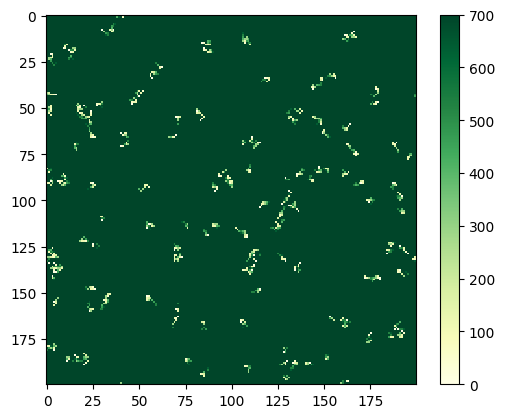

In [10]:
nrows = 200
ncols = 200
hs_tide = HerbivoreGrass(height=nrows,width=ncols,grass=True, verbose=True)
hs_tide.run_model(step_count=35)
gm_tide = generate_grass_map(hs_tide)
plot_grass_map(gm_tide)

In [11]:
# Create a grid the same size as the herbivore-grass model's grid
grid_spacing = 1
rmg = RasterModelGrid((hs_tide.grid.width, hs_tide.grid.height), grid_spacing)

# Create elevation field and have it slope down to the central channel
z = rmg.add_zeros("topographic__elevation", at="node")
# Set marsh system parameters
#Initial tidal values
tidal_parameters = {
    "tidal_range": 1.2,
    "tidal_period": 12.5,
    "mean_sea_level": 0.0
}

#Biomass properties
biomass_parameters = {
    "biomass_max":  np.array([700]),
    "max_inundation": np.ones(z.size) * 11.5,
    "min_inundation": np.zeros(z.size),
    "inundation_at_peak_biomass": np.ones(z.size) * 2.5
}

marsh_max_height = 0.45 + tidal_parameters["mean_sea_level"]
marsh_min_height = 0.1 + tidal_parameters["mean_sea_level"]
channel_depth = 0.6
channel_left_loc = ncols / 2 - 4
channel_right_loc = ncols / 2 + 6
marsh_slope = (marsh_max_height - marsh_min_height)/(ncols * grid_spacing - 55 * grid_spacing)
z[rmg.x_of_node < channel_left_loc * grid_spacing] = marsh_max_height - marsh_slope * rmg.x_of_node[rmg.x_of_node < channel_left_loc * grid_spacing]
z[rmg.x_of_node > channel_right_loc * grid_spacing] = marsh_min_height + marsh_slope * (rmg.x_of_node[rmg.x_of_node > channel_right_loc * grid_spacing] - 58 * grid_spacing)
channel = np.logical_and(rmg.x_of_node >= channel_left_loc * grid_spacing, rmg.x_of_node <= channel_right_loc * grid_spacing)
z[channel] = -channel_depth

# Have one open boundary on the south side
rmg.set_closed_boundaries_at_grid_edges(True, True, True, True)
open_nodes = np.arange(
    channel_left_loc-1, channel_right_loc+1, dtype=int
)  # IDs of open-boundary nodes (along channel at bottom/south boundary)
rmg.status_at_node[open_nodes] = rmg.BC_NODE_IS_FIXED_VALUE
# Remember the starting elevation so we can calculate cumulative erosion/deposition
initial_elev = np.zeros(rmg.number_of_nodes)
initial_elev[:] = z

# Initialize the biomass here from inundation-biomass relationship
inundation = rmg.add_zeros("inundation", at="node", clobber=True)
grid_biomass = rmg.add_zeros("biomass", at="node", clobber=True)
inundation[:] = floodTimeTrig(
    z, 
    tidal_parameters
)

grid_biomass[:] = solve_biomass_inundation_curve(
    inundation,
    biomass_parameters
)

roughness = rmg.add_zeros("roughness", at="link", clobber=True)
roughness_at_nodes = calculate_variable_roughness(rmg, depth_variable=False)

# Instantiate a TidalFlowCalculator  Landlab component
map_max_of_link_nodes_to_link(rmg, roughness_at_nodes, out=roughness)
# instantiate the TidalFlowCalculator
tfc_variable_roughness = TidalFlowCalculator(
    rmg, 
    tidal_range=tidal_parameters["tidal_range"], 
    tidal_period=tidal_parameters["tidal_period"] *3600, 
    roughness="roughness"
)

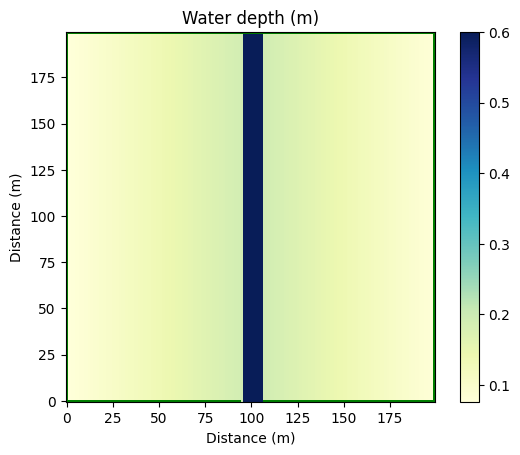

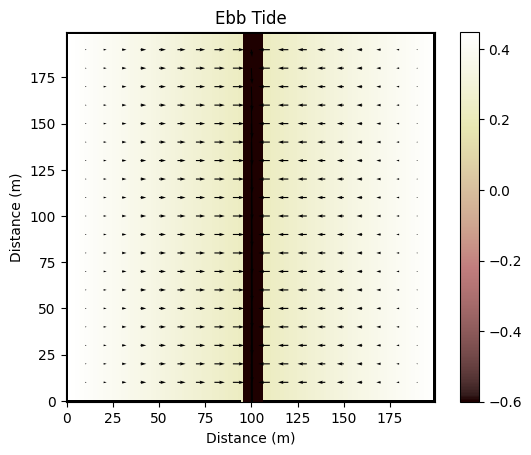

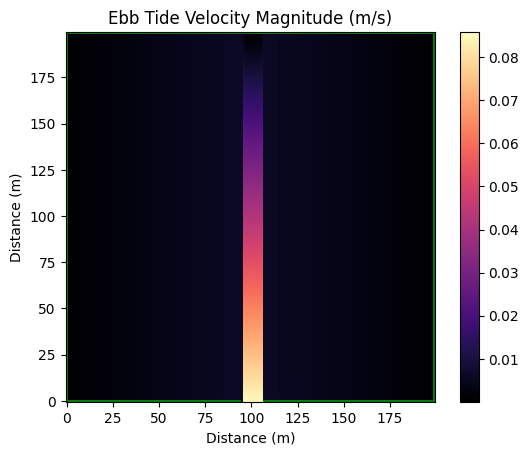

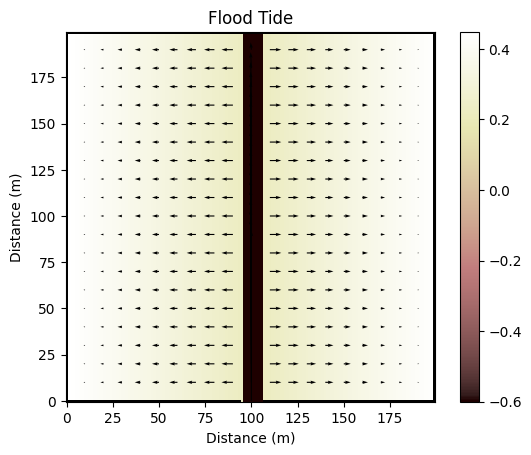

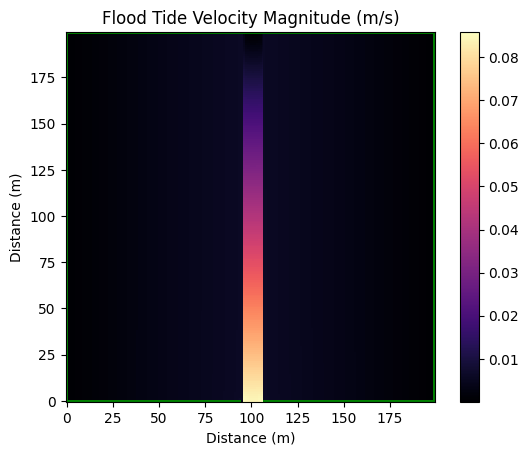

In [12]:
tfc_variable_roughness.run_one_step()
plot_tidal_flow(rmg, resample=10)

Now we modify the vegetation to reflect herbivory activity.

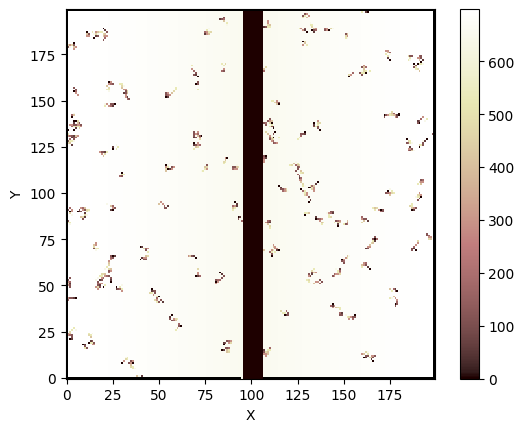

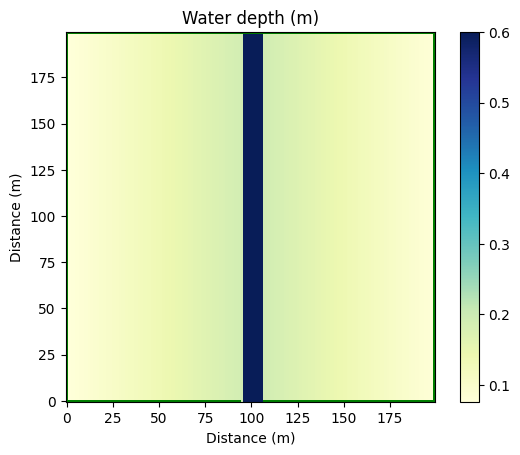

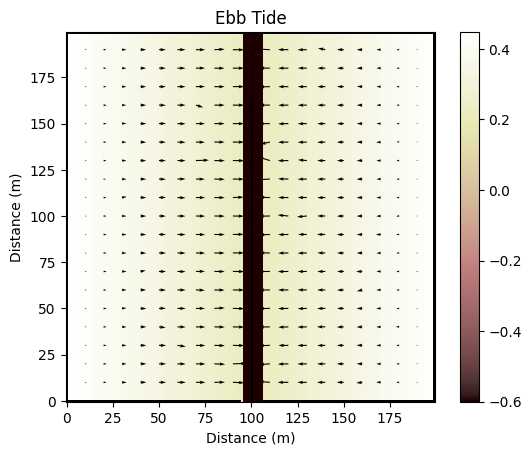

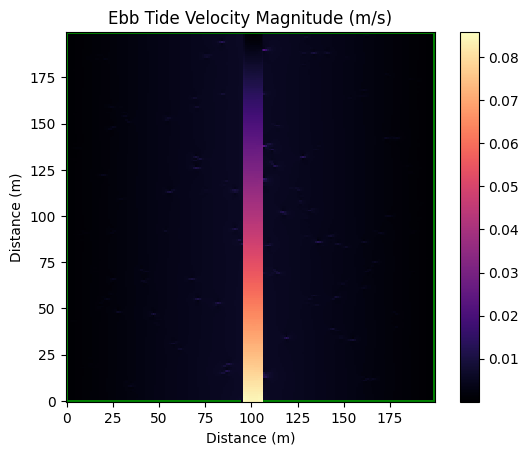

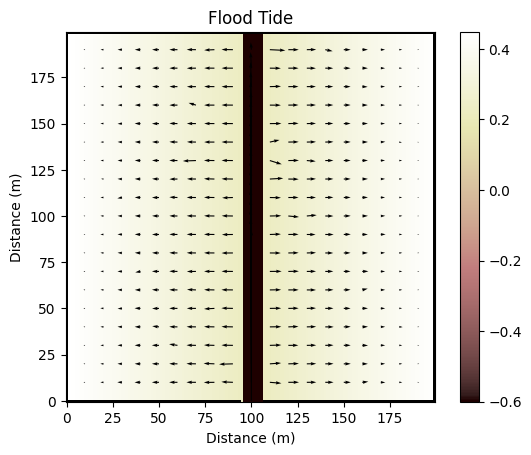

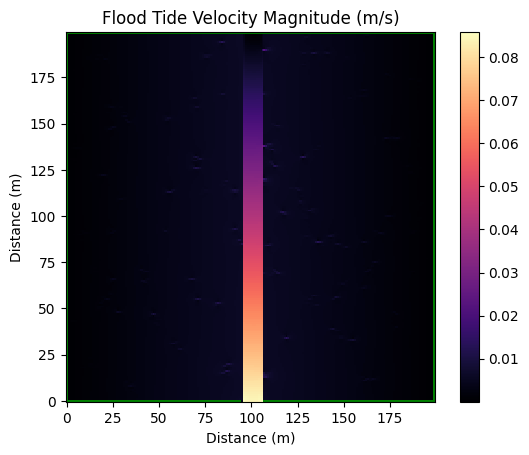

In [13]:
# Update grid biomass based on the grass map
filter = np.nonzero(gm_tide.flatten() < grid_biomass)
grid_biomass[filter] = gm_tide.flatten()[filter]
imshow_grid(rmg, rmg.at_node["biomass"])
roughness_at_nodes[:] = calculate_variable_roughness(rmg)
#imshow_grid(rmg, grid_biomass)
map_max_of_link_nodes_to_link(rmg, roughness_at_nodes, out=roughness)
tfc_variable_roughness.run_one_step()
plot_tidal_flow(rmg, resample=10)

Simply updating the roughness due to changes in biomass from herbivory causes changes in flood and ebb tide magnitude over a short term. Now let's investigate a 2-way couple to see how inundation affects the grazing behavior of the herbivores reinforces the changes in flow patterns.

## Two-way feedback

Here, we explore two-way feedback by running the two models iteratively. 

We intentionally neglect some important processes in this simulation for simplicity but we can add more erosion and deposition processes to investigate how these processes can reinforce each other over time. One could make the model more realistic by, for example, setting the grass regrowth time (a property of the GrassPatch agents in the ABM) to a value that depends on the inundation time (a property calculated from the Landlab depth field).

Next we define a new function `update_max_grass_by_inundation` that will change the "GrassPatch" max biomass to reflect the how inundation changes the maximum achievable biomass in a patch. While the biomass-inundation relationship used to predict low marsh biomass is based on some real data, the energy dyanmics in the herbivore model are artificial so showing how we can use data from a Landlab field to influence data associated with spatially distributed agents in a Mesa model:

In [14]:
# Create a grid the same size as the herbivore-grass model's grid
rmg = RasterModelGrid((hs_tide.grid.width, hs_tide.grid.height),xy_spacing=grid_spacing)

channel_left_loc = ncols / 2 - 4
channel_right_loc = ncols / 2 + 6
marsh_slope = (marsh_max_height - marsh_min_height)/(ncols * grid_spacing - channel_right_loc * grid_spacing)

# Create elevation field and have it slope down to the central channel
z = rmg.add_zeros("topographic__elevation", at="node")
z[rmg.x_of_node < channel_left_loc * grid_spacing] = (
    marsh_max_height - marsh_slope 
    * rmg.x_of_node[rmg.x_of_node < channel_left_loc * grid_spacing]
)
z[rmg.x_of_node > channel_right_loc * grid_spacing] = (
    marsh_min_height + marsh_slope 
    * (rmg.x_of_node[rmg.x_of_node > channel_right_loc * grid_spacing] 
       - channel_right_loc * grid_spacing)
)
z[channel] = -channel_depth

# Have one open boundary on the south side
rmg.set_closed_boundaries_at_grid_edges(True, True, True, True)
open_nodes = np.arange(
    channel_left_loc-1, channel_right_loc+1, dtype=int
)  # IDs of open-boundary nodes (along channel at bottom/south boundary)
rmg.status_at_node[open_nodes] = rmg.BC_NODE_IS_FIXED_VALUE
# Remember the starting elevation so we can calculate cumulative erosion/deposition
initial_elev = np.zeros(rmg.number_of_nodes)
initial_elev[:] = z

# Initialize the biomass here from inundation-biomass relationship
inundation = rmg.add_zeros("inundation", at="node", clobber=True)
grid_biomass = rmg.add_zeros("biomass", at="node", clobber=True)
roughness_at_nodes = rmg.add_zeros("roughness_at_nodes", at="node", clobber=True)
inundation[:] = floodTimeTrig(
    z, 
    tidal_parameters
)

grid_biomass[:] = solve_biomass_inundation_curve(
    inundation,
    biomass_parameters
)

roughness = rmg.add_zeros("roughness", at="link", clobber=True)
roughness_at_nodes[:] = calculate_variable_roughness(rmg, depth_variable=False)

# Instantiate a TidalFlowCalculator  Landlab component
map_max_of_link_nodes_to_link(rmg, roughness_at_nodes, out=roughness)
# instantiate the TidalFlowCalculator
tfc_variable_roughness = TidalFlowCalculator(
    rmg, 
    tidal_range=tidal_parameters["tidal_range"], 
    tidal_period=tidal_parameters["tidal_period"] * 3600, 
    roughness="roughness"
)
tfc_variable_roughness.run_one_step()

/tmp/ipykernel_10853/4289568898.py:263: UserWarning: Agent 1 is being placed with
place_agent() despite already having the position (71, 70). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(herbivore, (x, y))
/tmp/ipykernel_10853/4289568898.py:263: UserWarning: Agent 2 is being placed with
place_agent() despite already having the position (164, 147). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(herbivore, (x, y))
/tmp/ipykernel_10853/4289568898.py:263: UserWarning: Agent 3 is being placed with
place_agent() despite already having the position (25, 42). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(herbivore, (x, y))
/tmp/ipykernel_10853/4289568898.py:263: UserWarning: Agent 4 is being placed with
place_agent() despite already having 

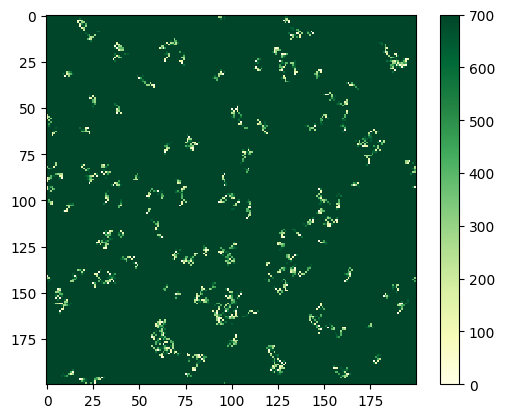

In [15]:
hs_tide = HerbivoreGrass(height=nrows,width=ncols,grass=True, verbose=False, herbivore_gain_from_food=40, grass_loss_from_grazing=120)
hs_tide.run_model(step_count=52)
gm_tide = generate_grass_map(hs_tide)
plot_grass_map(gm_tide)

In [16]:
def update_max_grass_by_inundation(hs_tide, grid, tide_properties, biomass_properties):
    grid.at_node["inundation"] = floodTimeTrig(grid.at_node["mean_water__depth"], tide_properties)
    grid.at_node["biomass"] = solve_biomass_inundation_curve(grid.at_node["inundation"], biomass_properties)
    biomass_matrix = grid.at_node["biomass"].reshape((hs_tide.width, hs_tide.height))
    for cell in hs_tide.grid.coord_iter():
        cell_content, (x, y) = cell
        if (biomass_matrix[x][y] < biomass_parameters['biomass_max']):
            for agent in cell_content:
                if type(agent) is GrassPatch:
                    if agent.biomass < biomass_matrix[x][y]:
                        agent.biomass = biomass_matrix[x][y]
                    agent.max_biomass = biomass_matrix[x][y]
    return grid


Run the integrated model in a time loop. Our algorithm performs the following sequence of calculations in each iteration:

- Get a copy of the current grass status as a 2D array
- Update the soil-creep coefficient Landlab field according to the grass status and the soil thickness
- Run soil creep for one time step and update the soil thickness (we could have used a DepthDependentLinearDiffuser for this, but here a simpler approach will suffice)
- Set grass in any cells with insufficient soil to be non-fully-grown
- Run the wolf-sheep-grass model for one time step

The data exchange happens in two function calls. `generate_grass_map` translates grass status data from the Mesa model's data structure to a Landlab field, and `limit_grass_by_soil` translates Landlab's soil thickness field into a restriction on grass status in the Mesa model's GrassPatch agents.

/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40286 is being placed with
place_agent() despite already having the position (53, 161). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40287 is being placed with
place_agent() despite already having the position (144, 26). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40288 is being placed with
place_agent() despite already having the position (29, 190). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.model.grid.place_agent(juvenile, self.pos)
/tmp/ipykernel_10853/4289568898.py:122: UserWarning: Agent 40289 is being placed with

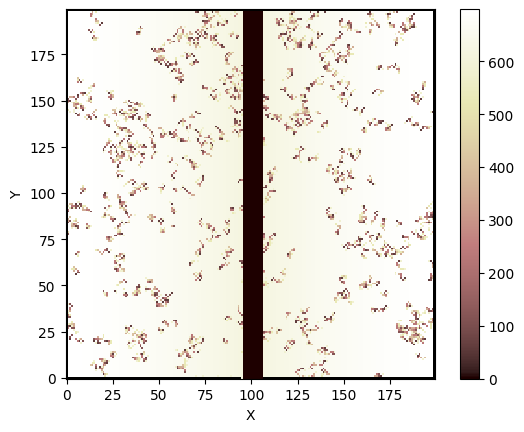

In [17]:
mesa_steps = 52
number_of_tides_per_step = 7 * 24 / tidal_parameters["tidal_period"]
hs_tide.run_model(mesa_steps)
for _ in range(2):
    gm_tide = generate_grass_map(hs_tide)
    # Update grid biomass based on the grass map
    filter = np.nonzero(gm_tide.flatten() < grid_biomass)
    grid_biomass[filter] = gm_tide.flatten()[filter]
    roughness_at_nodes[:] = calculate_variable_roughness(rmg)
    plt.figure()
    imshow_grid(rmg, rmg.at_node["biomass"])
    map_max_of_link_nodes_to_link(rmg, roughness_at_nodes, out=roughness)
    tfc_variable_roughness.run_one_step()
    z += number_of_tides_per_step * estimate_allochtonous_deposition_per_tide(rmg)
    rmg = update_max_grass_by_inundation(hs_tide, rmg, tidal_parameters, biomass_parameters)
    hs_tide.run_model(mesa_steps) 

    plt.figure()
    plot_grass_map(gm_tide)
    plot_tidal_flow(rmg, resample=10)

The next few plots examine the results to illustrate how the interaction of soil creep and grass consumption by mobile agents (sheep) has influenced the landscape:

In [ ]:
# Calculate and plot the erosion/deposition patterns
ero_dep = z - initial_elev
maxchange = np.amax(np.abs(ero_dep))
imshow_grid(
    rmg,
    ero_dep,
    vmin=-maxchange,
    vmax=maxchange,
    cmap="coolwarm_r",
    colorbar_label="Depth of soil accumulation (+) or loss (-), m",
)

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>